<h1>(Practice) Explaining Single Observations</h1>

<p>Revisit your (Optional) Extended Practice: Global Explanations with Shap assignment and add a new section for local explanations at the bottom.<br></p><p>Select at least 2 observations  (students) to produce local explanations for using either Lime or SHAP.</p><p><br></p>

# SOLUTION

## PREVIOUS ASSIGNMENT

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns",100)
# plt.style.use(['fivethirtyeight','seaborn-talk'])
# mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from sklearn.base import clone

## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)

plt.style.use(('ggplot','tableau-colorblind10'))

In [2]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-mat')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    float64
 3   address     395 non-null    object 
 4   famsize     395 non-null    object 
 5   Pstatus     395 non-null    object 
 6   Medu        395 non-null    float64
 7   Fedu        395 non-null    float64
 8   Mjob        395 non-null    object 
 9   Fjob        395 non-null    object 
 10  reason      395 non-null    object 
 11  guardian    395 non-null    object 
 12  traveltime  395 non-null    float64
 13  studytime   395 non-null    float64
 14  failures    395 non-null    float64
 15  schoolsup   395 non-null    object 
 16  famsup      395 non-null    object 
 17  paid        395 non-null    object 
 18  activities  395 non-null    object 
 19  nursery     395 non-null    o

school sex   age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F  18.0       U     GT3       A   4.0   4.0  at_home   teacher   
1     GP   F  17.0       U     GT3       T   1.0   1.0  at_home     other   
2     GP   F  15.0       U     LE3       T   1.0   1.0  at_home     other   
3     GP   F  15.0       U     GT3       T   4.0   2.0   health  services   
4     GP   F  16.0       U     GT3       T   3.0   3.0    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother         2.0        2.0       0.0       yes     no   no   
1  course   father         1.0        2.0       0.0        no    yes   no   
2   other   mother         1.0        2.0       3.0       yes     no  yes   
3    home   mother         1.0        3.0       0.0        no    yes  yes   
4    home   father         1.0        2.0       0.0        no    yes  yes   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \
0         no     yes    yes       no       no     4.0       3.0    4.0   1.0   
1         no      no    yes      yes       no     5.0       3.0    3.0   1.0   
2         no     yes    yes      yes       no     4.0       3.0    2.0   2.0   
3        yes     yes    yes      yes      yes     3.0       2.0    2.0   1.0   
4         no     yes    yes       no       no     4.0       3.0    2.0   1.0   

   Walc  health  absences    G1    G2    G3  
0   1.0     3.0       6.0   5.0   6.0   6.0  
1   1.0     3.0       4.0   5.0   5.0   6.0  
2   3.0     3.0      10.0   7.0   8.0  10.0  
3   1.0     5.0       2.0  15.0  14.0  15.0  
4   2.0     5.0       4.0   6.0  10.0  10.0

## Create a classification model to predict if a student will Pass or Fail their final Math Grade (G3).

## Create the Target

- Apply the same binning as the lesson to determine the classification target.

In [3]:
df['G3(%)'] = (df['G3']/20) *100
df['G3(%)'].head()

0    30.0
1    30.0
2    50.0
3    75.0
4    50.0
Name: G3(%), dtype: float64

In [4]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)

0      F
1      F
2      F
3      C
4      F
      ..
390    F
391    C
392    F
393    F
394    F
Name: G3(%), Length: 395, dtype: category
Categories (5, object): ['F' < 'D' < 'C' < 'B' < 'A']

In [5]:
df['FinalGrade'] = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
df

school sex   age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F  18.0       U     GT3       A   4.0   4.0   at_home   teacher   
1       GP   F  17.0       U     GT3       T   1.0   1.0   at_home     other   
2       GP   F  15.0       U     LE3       T   1.0   1.0   at_home     other   
3       GP   F  15.0       U     GT3       T   4.0   2.0    health  services   
4       GP   F  16.0       U     GT3       T   3.0   3.0     other     other   
..     ...  ..   ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M  20.0       U     LE3       A   2.0   2.0  services  services   
391     MS   M  17.0       U     LE3       T   3.0   1.0  services  services   
392     MS   M  21.0       R     GT3       T   1.0   1.0     other     other   
393     MS   M  18.0       R     LE3       T   3.0   2.0  services     other   
394     MS   M  19.0       U     LE3       T   1.0   1.0     other   at_home   

     reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0    course   mother         2.0        2.0       0.0       yes     no   no   
1    course   father         1.0        2.0       0.0        no    yes   no   
2     other   mother         1.0        2.0       3.0       yes     no  yes   
3      home   mother         1.0        3.0       0.0        no    yes  yes   
4      home   father         1.0        2.0       0.0        no    yes  yes   
..      ...      ...         ...        ...       ...       ...    ...  ...   
390  course    other         1.0        2.0       2.0        no    yes  yes   
391  course   mother         2.0        1.0       0.0        no     no   no   
392  course    other         1.0        1.0       3.0        no     no   no   
393  course   mother         3.0        1.0       0.0        no     no   no   
394  course   father         1.0        1.0       0.0        no     no   no   

    activities nursery higher internet romantic  famrel  freetime  goout  \
0           no     yes    yes       no       no     4.0       3.0    4.0   
1           no      no    yes      yes       no     5.0       3.0    3.0   
2           no     yes    yes      yes       no     4.0       3.0    2.0   
3          yes     yes    yes      yes      yes     3.0       2.0    2.0   
4           no     yes    yes       no       no     4.0       3.0    2.0   
..         ...     ...    ...      ...      ...     ...       ...    ...   
390         no     yes    yes       no       no     5.0       5.0    4.0   
391         no      no    yes      yes       no     2.0       4.0    5.0   
392         no      no    yes       no       no     5.0       5.0    3.0   
393         no      no    yes      yes       no     4.0       4.0    1.0   
394         no     yes    yes      yes       no     3.0       2.0    3.0   

     Dalc  Walc  health  absences    G1    G2    G3  G3(%) FinalGrade  
0     1.0   1.0     3.0       6.0   5.0   6.0   6.0   30.0          F  
1     1.0   1.0     3.0       4.0   5.0   5.0   6.0   30.0          F  
2     2.0   3.0     3.0      10.0   7.0   8.0  10.0   50.0          F  
3     1.0   1.0     5.0       2.0  15.0  14.0  15.0   75.0          C  
4     1.0   2.0     5.0       4.0   6.0  10.0  10.0   50.0          F  
..    ...   ...     ...       ...   ...   ...   ...    ...        ...  
390   4.0   5.0     4.0      11.0   9.0   9.0   9.0   45.0          F  
391   3.0   4.0     2.0       3.0  14.0  16.0  16.0   80.0          C  
392   3.0   3.0     3.0       3.0  10.0   8.0   7.0   35.0          F  
393   3.0   4.0     5.0       0.0  11.0  12.0  10.0   50.0          F  
394   3.0   3.0     5.0       5.0   8.0   9.0   9.0   45.0          F  

[395 rows x 35 columns]

In [6]:
## Define target as had a F or Above
df['target_F'] = df['FinalGrade'] == 'F'
df['target_F'].value_counts(1)

True     0.668354
False    0.331646
Name: target_F, dtype: float64

## Preprocessing

In [7]:
# ### Train Test Split
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


# ### Preprocessing + ColumnTransformer
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [8]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x288417400>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x177feda30>)],
                  verbose_feature_names_out=False)

In [9]:
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
58   15.0   1.0   2.0         1.0        2.0       0.0     4.0       3.0   
338  18.0   3.0   3.0         1.0        4.0       0.0     5.0       3.0   
291  17.0   4.0   3.0         1.0        3.0       0.0     4.0       2.0   

     goout  Dalc  Walc  health  absences  school_MS  sex_M  address_U  \
58     2.0   1.0   1.0     5.0       2.0        0.0    1.0        1.0   
338    3.0   1.0   1.0     1.0       7.0        0.0    0.0        1.0   
291    2.0   1.0   2.0     3.0       0.0        0.0    0.0        1.0   

     famsize_LE3  Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
58           1.0        1.0           0.0          0.0         1.0   
338          1.0        1.0           0.0          0.0         0.0   
291          0.0        1.0           0.0          1.0         0.0   

     Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
58             0.0           0.0           1.0          0.0         0.0   
338            1.0           0.0           0.0          0.0         0.0   
291            0.0           0.0           0.0          0.0         0.0   

     Fjob_services  Fjob_teacher  reason_course  reason_home  reason_other  \
58             0.0           0.0            0.0          1.0           0.0   
338            1.0           0.0            0.0          1.0           0.0   
291            1.0           0.0            0.0          0.0           0.0   

     reason_reputation  guardian_father  guardian_mother  guardian_other  \
58                 0.0              1.0              0.0             0.0   
338                0.0              0.0              1.0             0.0   
291                1.0              0.0              1.0             0.0   

     schoolsup_yes  famsup_yes  paid_yes  activities_yes  nursery_yes  \
58             1.0         1.0       0.0             1.0          1.0   
338            0.0         1.0       0.0             0.0          1.0   
291            0.0         1.0       1.0             0.0          1.0   

     higher_yes  internet_yes  romantic_yes  
58          1.0           1.0           0.0  
338         1.0           1.0           0.0  
291         1.0           1.0           0.0

In [10]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")

    ## training data
    print(f"[i] Training Data:")
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize, 
                                                  cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()
    
    
    print(dashes)
    ## training data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize, 
                                                  cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

## Modeling - Random Forest

> Note: students are only required to do 1 model.

### RandomForest

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       101
        True       1.00      1.00      1.00       195

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



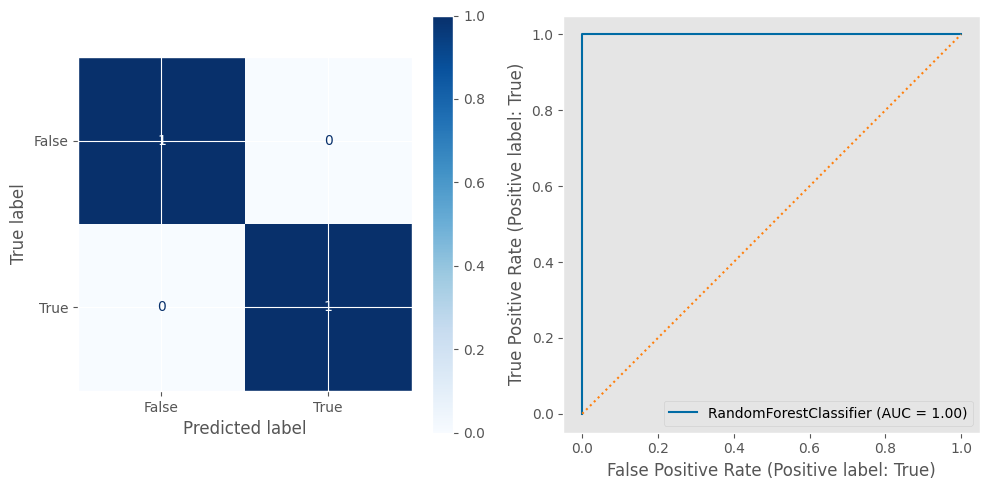

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.83      0.33      0.48        30
        True       0.77      0.97      0.86        69

    accuracy                           0.78        99
   macro avg       0.80      0.65      0.67        99
weighted avg       0.79      0.78      0.74        99



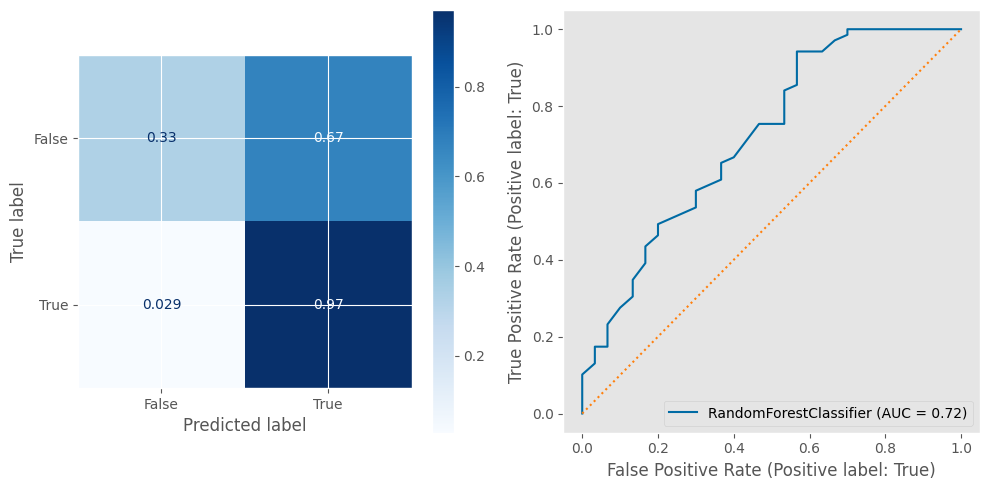

In [11]:
## fit random fores
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=SEED)
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

In [12]:
## Saving the feature importances
importances = pd.Series(rf_clf.feature_importances_, index= feature_names,
                       name='RandomForest Feature Importance')
ax = importances.sort_values().tail(15).plot(kind='barh',figsize=(8,8))
ax.set(title='Top 15 Most Important Features - Random Forest',
       ylabel='Feature', xlabel='Importance');

In [13]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [14]:
X_shap = shap.sample(X_test_df,nsamples=200,random_state=321)
X_shap

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
58   15.0   1.0   2.0         1.0        2.0       0.0     4.0       3.0   
338  18.0   3.0   3.0         1.0        4.0       0.0     5.0       3.0   
291  17.0   4.0   3.0         1.0        3.0       0.0     4.0       2.0   
281  17.0   3.0   2.0         1.0        1.0       1.0     4.0       4.0   
322  17.0   2.0   2.0         1.0        3.0       0.0     3.0       3.0   
..    ...   ...   ...         ...        ...       ...     ...       ...   
241  17.0   4.0   4.0         2.0        2.0       0.0     3.0       3.0   
65   16.0   4.0   3.0         3.0        2.0       0.0     5.0       4.0   
30   15.0   4.0   4.0         1.0        2.0       0.0     5.0       4.0   
141  16.0   2.0   2.0         2.0        1.0       2.0     2.0       3.0   
296  19.0   4.0   4.0         2.0        2.0       0.0     2.0       3.0   

     goout  Dalc  Walc  health  absences  school_MS  sex_M  address_U  \
58     2.0   1.0   1.0     5.0       2.0        0.0    1.0        1.0   
338    3.0   1.0   1.0     1.0       7.0        0.0    0.0        1.0   
291    2.0   1.0   2.0     3.0       0.0        0.0    0.0        1.0   
281    4.0   3.0   4.0     3.0      19.0        0.0    1.0        1.0   
322    2.0   2.0   2.0     3.0       3.0        0.0    0.0        0.0   
..     ...   ...   ...     ...       ...        ...    ...        ...   
241    3.0   2.0   3.0     4.0       2.0        0.0    1.0        0.0   
65     3.0   1.0   2.0     1.0       2.0        0.0    0.0        1.0   
30     2.0   3.0   4.0     5.0       0.0        0.0    1.0        1.0   
141    3.0   2.0   2.0     2.0       8.0        0.0    1.0        1.0   
296    4.0   2.0   3.0     2.0       0.0        0.0    0.0        1.0   

     famsize_LE3  Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
58           1.0        1.0           0.0          0.0         1.0   
338          1.0        1.0           0.0          0.0         0.0   
291          0.0        1.0           0.0          1.0         0.0   
281          1.0        0.0           0.0          0.0         0.0   
322          1.0        1.0           0.0          0.0         0.0   
..           ...        ...           ...          ...         ...   
241          1.0        0.0           0.0          0.0         0.0   
65           1.0        1.0           0.0          0.0         0.0   
30           0.0        1.0           0.0          1.0         0.0   
141          1.0        1.0           0.0          0.0         0.0   
296          0.0        1.0           0.0          1.0         0.0   

     Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
58             0.0           0.0           1.0          0.0         0.0   
338            1.0           0.0           0.0          0.0         0.0   
291            0.0           0.0           0.0          0.0         0.0   
281            0.0           1.0           0.0          0.0         0.0   
322            1.0           0.0           0.0          0.0         0.0   
..             ...           ...           ...          ...         ...   
241            0.0           1.0           0.0          0.0         1.0   
65             0.0           1.0           0.0          0.0         0.0   
30             0.0           0.0           0.0          0.0         0.0   
141            1.0           0.0           0.0          0.0         0.0   
296            0.0           0.0           0.0          0.0         1.0   

     Fjob_services  Fjob_teacher  reason_course  reason_home  reason_other  \
58             0.0           0.0            0.0          1.0           0.0   
338            1.0           0.0            0.0          1.0           0.0   
291            1.0           0.0            0.0          0.0           0.0   
281            1.0           0.0            0.0          1.0           0.0   
322            1.0           0.0            1.0          0.0           0.0   
..    

In [15]:
## get the corresponding y-values
y_shap = y_test.loc[X_shap.index].astype(int)
y_shap 

58     1
338    0
291    0
281    1
322    1
      ..
241    1
65     0
30     1
141    1
296    1
Name: target_F, Length: 99, dtype: int64

In [16]:
X_shap = X_shap.reset_index(drop=True)
y_shap = y_shap.reset_index(drop=True)
X_shap

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
0   15.0   1.0   2.0         1.0        2.0       0.0     4.0       3.0   
1   18.0   3.0   3.0         1.0        4.0       0.0     5.0       3.0   
2   17.0   4.0   3.0         1.0        3.0       0.0     4.0       2.0   
3   17.0   3.0   2.0         1.0        1.0       1.0     4.0       4.0   
4   17.0   2.0   2.0         1.0        3.0       0.0     3.0       3.0   
..   ...   ...   ...         ...        ...       ...     ...       ...   
94  17.0   4.0   4.0         2.0        2.0       0.0     3.0       3.0   
95  16.0   4.0   3.0         3.0        2.0       0.0     5.0       4.0   
96  15.0   4.0   4.0         1.0        2.0       0.0     5.0       4.0   
97  16.0   2.0   2.0         2.0        1.0       2.0     2.0       3.0   
98  19.0   4.0   4.0         2.0        2.0       0.0     2.0       3.0   

    goout  Dalc  Walc  health  absences  school_MS  sex_M  address_U  \
0     2.0   1.0   1.0     5.0       2.0        0.0    1.0        1.0   
1     3.0   1.0   1.0     1.0       7.0        0.0    0.0        1.0   
2     2.0   1.0   2.0     3.0       0.0        0.0    0.0        1.0   
3     4.0   3.0   4.0     3.0      19.0        0.0    1.0        1.0   
4     2.0   2.0   2.0     3.0       3.0        0.0    0.0        0.0   
..    ...   ...   ...     ...       ...        ...    ...        ...   
94    3.0   2.0   3.0     4.0       2.0        0.0    1.0        0.0   
95    3.0   1.0   2.0     1.0       2.0        0.0    0.0        1.0   
96    2.0   3.0   4.0     5.0       0.0        0.0    1.0        1.0   
97    3.0   2.0   2.0     2.0       8.0        0.0    1.0        1.0   
98    4.0   2.0   3.0     2.0       0.0        0.0    0.0        1.0   

    famsize_LE3  Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
0           1.0        1.0           0.0          0.0         1.0   
1           1.0        1.0           0.0          0.0         0.0   
2           0.0        1.0           0.0          1.0         0.0   
3           1.0        0.0           0.0          0.0         0.0   
4           1.0        1.0           0.0          0.0         0.0   
..          ...        ...           ...          ...         ...   
94          1.0        0.0           0.0          0.0         0.0   
95          1.0        1.0           0.0          0.0         0.0   
96          0.0        1.0           0.0          1.0         0.0   
97          1.0        1.0           0.0          0.0         0.0   
98          0.0        1.0           0.0          1.0         0.0   

    Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
0             0.0           0.0           1.0          0.0         0.0   
1             1.0           0.0           0.0          0.0         0.0   
2             0.0           0.0           0.0          0.0         0.0   
3             0.0           1.0           0.0          0.0         0.0   
4             1.0           0.0           0.0          0.0         0.0   
..            ...           ...           ...          ...         ...   
94            0.0           1.0           0.0          0.0         1.0   
95            0.0           1.0           0.0          0.0         0.0   
96            0.0           0.0           0.0          0.0         0.0   
97            1.0           0.0           0.0          0.0         0.0   
98            0.0           0.0           0.0          0.0         1.0   

    Fjob_services  Fjob_teacher  reason_course  reason_home  reason_other  \
0             0.0           0.0            0.0          1.0           0.0   
1             1.0           0.0            0.0          1.0           0.0   
2             1.0           0.0            0.0          0.0           0.0   
3             1.0           0.0            0.0          1.0           0.0   
4             1.0           0.0            1.0          0.0           0.0   
..            ...           ...            ...          ...

### Model Explainer

In [17]:
explainer = shap.Explainer(rf_clf)
explainer

In [18]:
## Getting the shap values
shap_values = explainer(X_shap)
shap_values.shape

(99, 43, 2)

In [19]:
shap_vals_F = shap_values[:,:,1]
shap_vals_F.shape

(99, 43)

In [20]:
shap.summary_plot(shap_vals_F)#,max_display=10)

## THIS ASSIGNMENT 

###  Using Top Features to Select Examples
- Failures
- Medu
- schoolsup_Yes
- absences
- Fedu

#### failures

<AxesSubplot:xlabel='failures', ylabel='Count'>

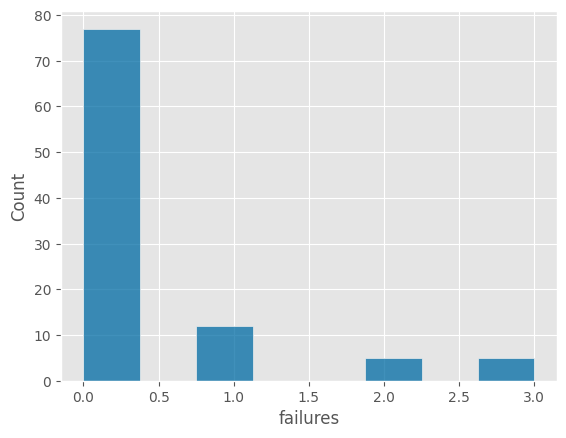

In [21]:
sns.histplot(X_shap['failures'])

In [22]:
# saving filters where True = Failiing
filt_failures = X_shap['failures'] > 0
filt_failures.value_counts()

False    77
True     22
Name: failures, dtype: int64

#### Medu

<AxesSubplot:xlabel='Medu', ylabel='Count'>

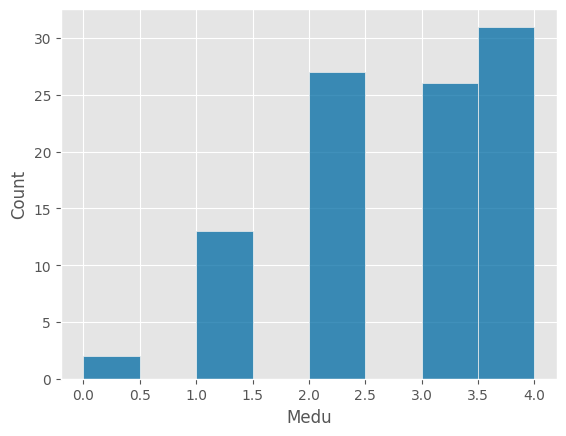

In [23]:
sns.histplot(X_shap['Medu'])

In [24]:
filt_medu = X_shap['Medu'] < 3
filt_medu.value_counts()

False    57
True     42
Name: Medu, dtype: int64

#### SchoolSup == Yes

In [25]:
sns.histplot(X_shap['schoolsup_yes']);

In [26]:
filt_schoolsup = X_shap['schoolsup_yes'] == True
filt_schoolsup.value_counts()

False    87
True     12
Name: schoolsup_yes, dtype: int64

#### Absences

<AxesSubplot:xlabel='absences', ylabel='Count'>

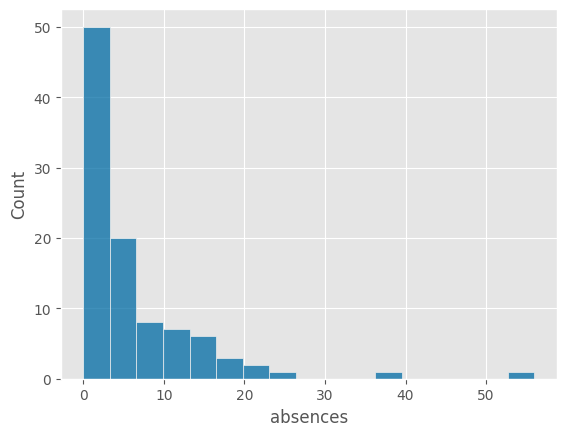

In [27]:
sns.histplot(X_shap['absences'])

In [28]:
filt_absences = X_shap['absences'] > 3
filt_absences.value_counts()

False    50
True     49
Name: absences, dtype: int64

#### Fedu

<AxesSubplot:xlabel='Fedu', ylabel='Count'>

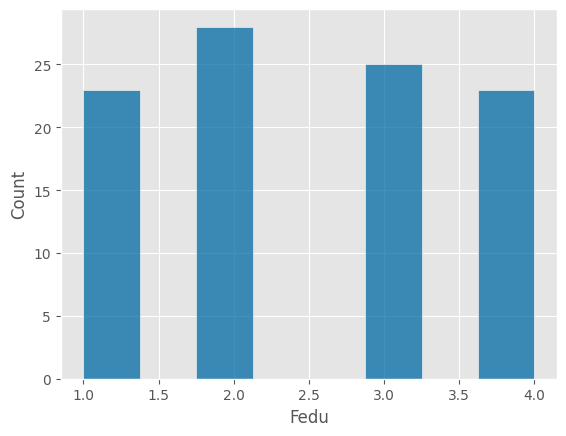

In [29]:
sns.histplot(X_shap['Fedu'])

In [30]:
filt_fedu = X_shap["Fedu"] < 3
filt_fedu.value_counts()

True     51
False    48
Name: Fedu, dtype: int64

### Group A: 


- High Failure
- Low Mother Education
- Additional School Support
- High Absences
- Low Father Education

In [31]:
X_shap[ filt_failures & filt_medu & filt_schoolsup & filt_absences & filt_fedu]

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
89  16.0   2.0   2.0         2.0        2.0       1.0     4.0       3.0   

    goout  Dalc  Walc  health  absences  school_MS  sex_M  address_U  \
89    3.0   2.0   2.0     5.0      14.0        0.0    0.0        1.0   

    famsize_LE3  Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
89          1.0        1.0           0.0          0.0         1.0   

    Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
89            0.0           0.0           1.0          0.0         0.0   

    Fjob_services  Fjob_teacher  reason_course  reason_home  reason_other  \
89            0.0           0.0            1.0          0.0           0.0   

    reason_reputation  guardian_father  guardian_mother  guardian_other  \
89                0.0              1.0              0.0             0.0   

    schoolsup_yes  famsup_yes  paid_yes  activities_yes  nursery_yes  \
89            1.0         0.0       0.0             1.0          1.0   

    higher_yes  internet_yes  romantic_yes  
89         1.0           1.0           0.0

In [32]:
idx_example_A = 89
print(f"Failed? = {y_shap.loc[idx_example_A]}")
X_shap.loc[idx_example_A]

Failed? = 1


age                  16.0
Medu                  2.0
Fedu                  2.0
traveltime            2.0
studytime             2.0
failures              1.0
famrel                4.0
freetime              3.0
goout                 3.0
Dalc                  2.0
Walc                  2.0
health                5.0
absences             14.0
school_MS             0.0
sex_M                 0.0
address_U             1.0
famsize_LE3           1.0
Pstatus_T             1.0
Mjob_at_home          0.0
Mjob_health           0.0
Mjob_other            1.0
Mjob_services         0.0
Mjob_teacher          0.0
Fjob_at_home          1.0
Fjob_health           0.0
Fjob_other            0.0
Fjob_services         0.0
Fjob_teacher          0.0
reason_course         1.0
reason_home           0.0
reason_other          0.0
reason_reputation     0.0
guardian_father       1.0
guardian_mother       0.0
guardian_other        0.0
schoolsup_yes         1.0
famsup_yes            0.0
paid_yes              0.0
activities_y

### Group B

- High Failure
- **High Mother Education**
- Additional School Support
- High Absences
- Low Father Education

In [33]:
X_shap[ filt_failures & ~filt_medu & filt_schoolsup & filt_absences & filt_fedu]

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
84  15.0   3.0   2.0         2.0        2.0       2.0     4.0       4.0   

    goout  Dalc  Walc  health  absences  school_MS  sex_M  address_U  \
84    4.0   1.0   4.0     3.0       6.0        0.0    1.0        0.0   

    famsize_LE3  Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
84          0.0        1.0           0.0          0.0         1.0   

    Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
84            0.0           0.0           0.0          0.0         1.0   

    Fjob_services  Fjob_teacher  reason_course  reason_home  reason_other  \
84            0.0           0.0            1.0          0.0           0.0   

    reason_reputation  guardian_father  guardian_mother  guardian_other  \
84                0.0              0.0              1.0             0.0   

    schoolsup_yes  famsup_yes  paid_yes  activities_yes  nursery_yes  \
84            1.0         1.0       0.0             0.0          1.0   

    higher_yes  internet_yes  romantic_yes  
84         1.0           1.0           1.0

In [34]:
idx_example_B = 84
print(f"Failed? = {y_shap.iloc[idx_example_B]}")
X_shap.iloc[idx_example_B]

Failed? = 1


age                  15.0
Medu                  3.0
Fedu                  2.0
traveltime            2.0
studytime             2.0
failures              2.0
famrel                4.0
freetime              4.0
goout                 4.0
Dalc                  1.0
Walc                  4.0
health                3.0
absences              6.0
school_MS             0.0
sex_M                 1.0
address_U             0.0
famsize_LE3           0.0
Pstatus_T             1.0
Mjob_at_home          0.0
Mjob_health           0.0
Mjob_other            1.0
Mjob_services         0.0
Mjob_teacher          0.0
Fjob_at_home          0.0
Fjob_health           0.0
Fjob_other            1.0
Fjob_services         0.0
Fjob_teacher          0.0
reason_course         1.0
reason_home           0.0
reason_other          0.0
reason_reputation     0.0
guardian_father       0.0
guardian_mother       1.0
guardian_other        0.0
schoolsup_yes         1.0
famsup_yes            1.0
paid_yes              0.0
activities_y

## Visualizing Individual Shap for Selected Examples

In [35]:
y_pred = pd.Series(rf_clf.predict(X_shap), index=X_shap.index)

### Group A 

In [36]:
print(f"Example of a Student In Group A")
print(f"True Class: Fail = {y_shap.loc[idx_example_A]}")
print(f"Predicted Class: Fail = {y_pred.loc[idx_example_A]}")

Example of a Student In Group A
True Class: Fail = 1
Predicted Class: Fail = True


##### Force Plot

In [37]:
## Individual forceplot of example high drinker 
shap.force_plot(explainer.expected_value[1],
                shap_values=shap_vals_F[idx_example_A].values,
               features=X_shap.iloc[idx_example_A])

![png](images/force_plot_A.png)

- As we can see in the force plot above for group A:
    - While there were several factors decreasing the likihood of a predicted failing G3 grade, such as not receiving supplemental assistance from the family and the father working at work. There were many more features pushing the prediction in the opposite direction such as:
    - failing another subjects
    - receiving supplemental support from the school
    - high number of absences
    - etc.

### Group B:

In [38]:
print(f"Example of a Student In Group B")
print(f"True Class: Fail = {y_shap.loc[idx_example_B]}")
print(f"Predicted Class: Fail = {y_pred.loc[idx_example_B]}")

Example of a Student In Group B
True Class: Fail = 1
Predicted Class: Fail = True


In [39]:
## Individual forceplot of example high drinker 
shap.force_plot(explainer.expected_value[1],
                shap_values=shap_vals_F[idx_example_B].values,
               features=X_shap.loc[idx_example_B])


![png](images/force_plot_B.png)

- As we can see in the example from Group B:
    - There very few factors that would have decreased the chances of predicting a failure, and there were many that increased the likihood of a predicted failure, such as:
        - Failing 2 subjects
        - Receiving supplemental support from the school
        - High weekend alcohol consumption.

### Using the LimeTabularExplainer

In [40]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(
    training_data=X_shap.values,
    feature_names=X_shap.columns,
    class_names=['Pass', 'Fail'],
    mode='classification'
)
lime_explainer

##### Group A - Failed

In [41]:
X_shap.iloc[idx_example_A].head()

age           16.0
Medu           2.0
Fedu           2.0
traveltime     2.0
studytime      2.0
Name: 89, dtype: float64

In [42]:
exp = lime_explainer.explain_instance(X_shap.iloc[idx_example_A], rf_clf.predict_proba)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


![png](images/lime_explanation_A.png)

- As we can see in the LIME explanation above, there were many factors contributing to the predicted failure for student A, such as:
    - Failing 1 class in the past
    - Receiving extra educational support
    - high number of absences  (14)
    - Low parental education levls, (Medu=2, Fedu=2)
- The only feature that decreased the likelihood of predicting a failure as the student not receiving supplemental help from their family.

In [43]:
## getting the explanation values as a list
exp_df = pd.DataFrame(exp.as_list(),columns=['Effect','Value'])
exp_df

Effect     Value
0               failures > 0.00  0.104008
1          schoolsup_yes > 0.00  0.075852
2               absences > 8.00  0.055162
3                  Medu <= 2.00  0.054226
4           Mjob_health <= 0.00  0.039596
5  0.00 < reason_course <= 1.00  0.034846
6          reason_other <= 0.00  0.031431
7                  Fedu <= 2.00  0.029140
8     reason_reputation <= 0.00  0.028775
9            famsup_yes <= 0.00 -0.027886

### Group B

In [44]:
exp = lime_explainer.explain_instance(X_shap.iloc[idx_example_B], rf_clf.predict_proba)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


![png](Images/lime_explanation_B.png)

- As we can see above, student B also had many factors contributing to the predicted failure, such as:
    - 2 previous failures
    - receiving supplemental support from the school
    - Mother not having a healthcare job
    - attending the school for the specific course
    -  receiving supplemental support from their family,etc.
- The only feature that decreased the chance of a predicted failure was this student being male.


In [45]:
## getting the explanation values as a list
exp_df = pd.DataFrame(exp.as_list(),columns=['Effect','Value'])
exp_df

Effect     Value
0               failures > 0.00  0.106178
1          schoolsup_yes > 0.00  0.076343
2           Mjob_health <= 0.00  0.039821
3     reason_reputation <= 0.00  0.034873
4          reason_other <= 0.00  0.034776
5  0.00 < reason_course <= 1.00  0.032959
6     0.00 < famsup_yes <= 1.00  0.032069
7          0.00 < sex_M <= 1.00 -0.030249
8          Fjob_teacher <= 0.00  0.030096
9                  Fedu <= 2.00  0.029337